In [26]:
# This model seems to be overfitting a lot
#  TOBIT 
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score



In [27]:

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-60)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [28]:


# 1) Load and feature‐engineer
df = pd.read_csv("/Users/tobitlouis/Desktop/Data/S27FE-10K.csv")
df = make_features(df)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

# 2) Define features & target
feature_cols = [
    'seconds_in_bucket', 'mid_price', 'spread',
    'imbalance','imbalance_lag1','imbalance_lag2',
    'book_pressure','book_pressure_lag1','book_pressure_lag2',
    'microprice','normalized_spread','OBI_L2',
    'LOB_entropy','LOB_entropy_normalized',
    'log_return','log_return_lag1','log_return_lag2',
    'bipower_var','wap','log_wap_return',
    'rolling_vol_30','rolling_imbalance_mean_30',
]
target_col = 'rv_future'

X = df[feature_cols].values    # shape (n_samples, n_features)
y = df[target_col].values      # shape (n_samples,)

# 3) Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 4) Split train+val further into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)
# Note: 0.25 of 0.8 leaves 0.6 train / 0.2 val / 0.2 test

# 5) Scale features *fit only on training* then transform all sets
scaler = StandardScaler()
X_train_scaled   = scaler.fit_transform(X_train)
X_val_scaled     = scaler.transform(X_val)
X_test_scaled    = scaler.transform(X_test)

# Now you have:
#   X_train_scaled, y_train
#   X_val_scaled,   y_val
#   X_test_scaled,  y_test


/var/folders/1x/1h6q844j3q17xnp4kqxpsnz00000gn/T/ipykernel_72443/1733880287.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


[0]	validation_0-rmse:0.00111
[1]	validation_0-rmse:0.00109
[2]	validation_0-rmse:0.00107
[3]	validation_0-rmse:0.00106
[4]	validation_0-rmse:0.00104
[5]	validation_0-rmse:0.00103
[6]	validation_0-rmse:0.00101
[7]	validation_0-rmse:0.00100
[8]	validation_0-rmse:0.00099
[9]	validation_0-rmse:0.00098
[10]	validation_0-rmse:0.00097
[11]	validation_0-rmse:0.00096
[12]	validation_0-rmse:0.00095
[13]	validation_0-rmse:0.00094
[14]	validation_0-rmse:0.00093
[15]	validation_0-rmse:0.00093
[16]	validation_0-rmse:0.00092
[17]	validation_0-rmse:0.00091
[18]	validation_0-rmse:0.00090
[19]	validation_0-rmse:0.00089
[20]	validation_0-rmse:0.00089
[21]	validation_0-rmse:0.00088
[22]	validation_0-rmse:0.00087
[23]	validation_0-rmse:0.00087
[24]	validation_0-rmse:0.00086
[25]	validation_0-rmse:0.00086
[26]	validation_0-rmse:0.00086
[27]	validation_0-rmse:0.00085
[28]	validation_0-rmse:0.00084
[29]	validation_0-rmse:0.00084
[30]	validation_0-rmse:0.00084
[31]	validation_0-rmse:0.00083
[32]	validation_0-

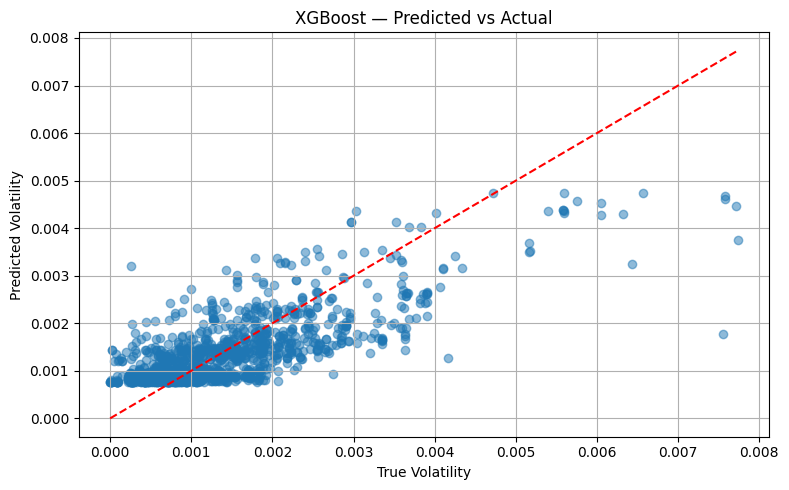

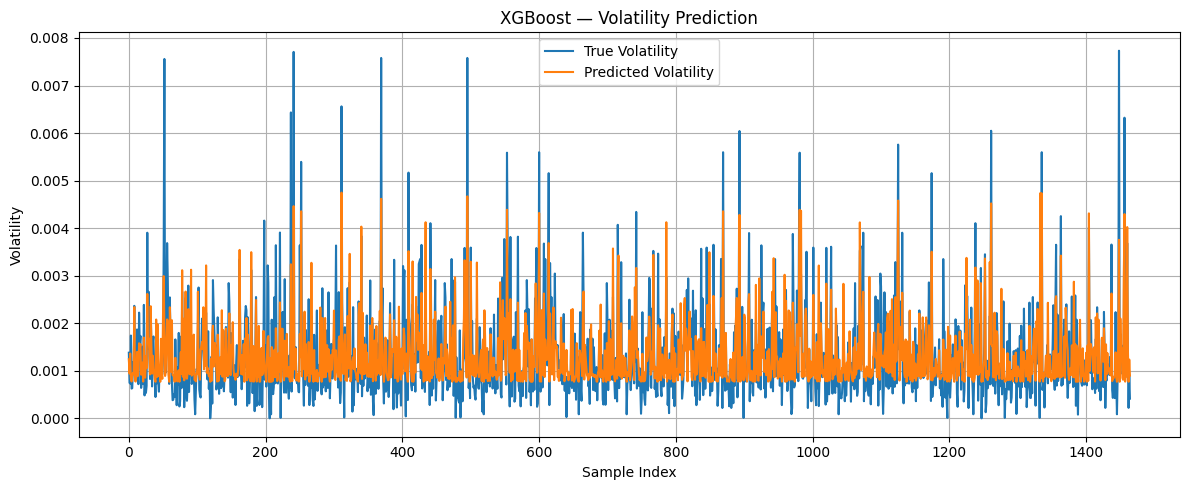

In [29]:


# -------------------
# Train the XGBoost model with early stopping
# -------------------
xgb_model = xgb.XGBRegressor(
    n_estimators=200,            # max trees
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
    early_stopping_rounds=10     # must be passed here
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],  # use validation set here
    verbose=True
)

# -------------------
# Predict and evaluate on test set
# -------------------
y_pred = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_test, y_pred)


print("✅ XGBoost Results:")
print(f"  MSE: {mse:.8f}")
print(f"  R²:  {r2:.4f}")
print("QLIKE:", ql)

# -------------------
# Plot predictions
# -------------------
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("XGBoost — Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot true vs predicted volatility on the test set
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="True Volatility")
plt.plot(y_pred, label="Predicted Volatility")
plt.legend()
plt.title("XGBoost — Volatility Prediction")
plt.xlabel("Sample Index")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()



Fold 1/5
  MSE: 0.00000055, R²: 0.5942

Fold 2/5
  MSE: 0.00000048, R²: 0.6046

Fold 3/5
  MSE: 0.00000046, R²: 0.6185

Fold 4/5
  MSE: 0.00000044, R²: 0.6495

Fold 5/5
  MSE: 0.00000051, R²: 0.6400

✅ Cross-Validation Summary:
  Avg MSE: 0.00000049 ± 0.00000004
  Avg R²:  0.6214 ± 0.0208


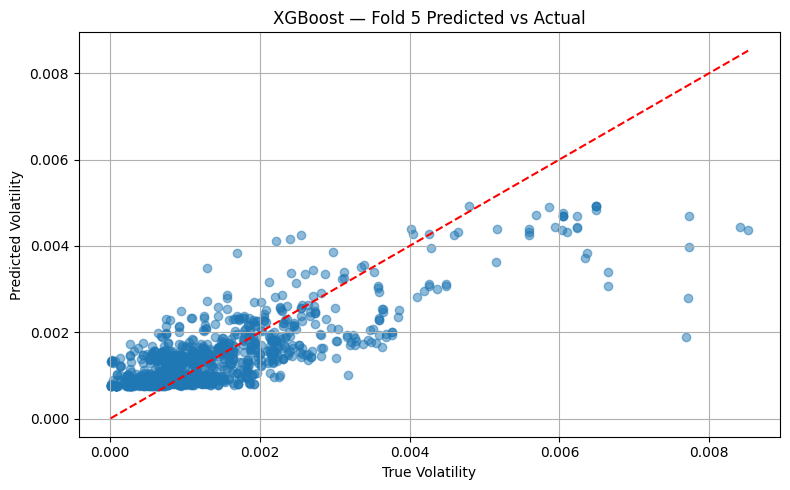

In [30]:
from sklearn.model_selection import KFold

# 5-fold CV over the training+validation set
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mse_scores = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval_scaled), start=1):
    print(f"\nFold {fold}/5")

    # create fold‐specific splits
    X_train_fold = X_trainval_scaled[train_idx]
    y_train_fold = y_trainval[train_idx]
    X_val_fold   = X_trainval_scaled[val_idx]
    y_val_fold   = y_trainval[val_idx]

    # instantiate  XGB
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        objective="reg:squarederror"
    )

    # train on this fold
    model.fit(X_train_fold, y_train_fold)

    # predict on validation fold
    y_pred_fold = model.predict(X_val_fold)
    y_true_fold = y_val_fold

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2  = r2_score(y_true_fold, y_pred_fold)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"  MSE: {mse:.8f}, R²: {r2:.4f}")

# summary
print("\n✅ Cross-Validation Summary:")
print(f"  Avg MSE: {np.mean(mse_scores):.8f} ± {np.std(mse_scores):.8f}")
print(f"  Avg R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# scatter for last fold
plt.figure(figsize=(8,5))
plt.scatter(y_true_fold, y_pred_fold, alpha=0.5)
mn, mx = y_true_fold.min(), y_true_fold.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title(f"XGBoost — Fold {fold} Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
